# Project Part F: All Together Now

![](banner_project.jpg)

In [1]:
analyst = "Donovan Bradley" # Replace this with your name

In [2]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)
options(repr.matrix.max.rows=674)
update_geom_defaults("point", list(size=1))
update_geom_defaults("col", list(fill=PALETTE[1]))
out(5.8,2.1)

## Introduction

### Decision

Recommend a portfolio of 12 company investments that will maximize 12-month profit on a \$1,000,000 investment.

### Approach

Retrieve a public company fundamentals dataset comprising thousands of US companies from quarters 1, 2, 3, and 4 of year 2017 + company stock price data for those companies from quarter 4 of year 2018.

Prepare the data so that each company and its associated information is represented as a single observation.

Apply various descriptive statistics and data visualizations to look for interesting patterns and inter-company relationships.

Transform the dataset using variable filtration, imputation, principal component analysis, and other methods to ready it for predictive model construction.

Build models to predict whether stock price will grow more than 30% over 12 months, given 12 months of past company fundamentals data, using machine learning model construction methods.  Evaluate and tune the models for best business performance.

Build models to predict how much stock price will grow over 12 months, given 12 months of past company fundamentals data, using machine learning model construction methods.  Evaluate and tune the models for best business performance.

Identify the best performing model.

Retrieve an investment opportunities dataset, comprising fundamentals for some set of public companies over some one-year period. Transform the representation of the investment opportunities to match the representation expected by the best performing model, leveraging previous analysis.

Use the best performing model to make predictions about the investment opportunities and accordingly recommend a portfolio of 12 company investments.

### Data Source

Data files:

* Data Dictionary.csv
* Company Fundamentals 2017.csv
* Company Fundamentals 2018.csv

The datasets and accompanying data dictionary are sourced from ...

* Wharton Research Data Services > Compustat - Capital IQ from Standard & Poor's > North America - Daily > Fundamentals Quarterly (https://wrds-www.wharton.upenn.edu/)

  * Date Variable: Data Date
  * Date Range: 2017-01 to 2017-12 -or- 2018-01 to 2018-12
  * Company Codes: Search the entire database
    * Consolidtaion Level: C, Output
    * Industry Format: INDL, FS, Output
    * Data Format: STD, Output
    * Population Source: D, Output
    * Quarter Type: Fiscal View, Output
    * Currency: USD, Output (not CAD)
    * Company Status: Active, Output (not Inactive)
  * Variable Types: Data Items, Select All (674)
  * Query output:
    * Output format: comma-delimited text
    * Compression type: None
    * Data format: MMDDYY10

The datasets are restricted to select US active, publicly held companies that reported quarterly measures including stock prices for 1st, 2nd, 3rd, and 4th quarters in years 2017 and 2018.  All non-missing stock prices exceed $3 per share.  File formats are all comma-separated values (CSV).

The data dictionary is from Variable Descriptions tab, copied to Excel, saved in csv format.

_**For this project, do not source any additional data from year 2019.**_

## Business Model & Business Parameters

The business model is ...

<p style="text-indent: 15px;">
$\begin{align}
& \textsf{profit} = \left( \sum_{i \in \textsf{portfolio}} (1 + \textsf{growth}_i) \times \textsf{allocation}_i \right) - \textsf{budget} \\ \\
& \textsf{profit rate} = \textsf{profit} \div \textsf{budget} \\ \\
& \textsf{budget} = \sum_{i \in \textsf{portfolio}} \textsf{allocation}_i \\ \\
\end{align}$


Business parameters include ...

* $\textsf{budget}$ is total investment to allocate across the companies in the portfolio<br>
* $\textsf{portfolio size}$ is number of companies in the portfolio<br>
* $\textsf{allocation}$ is vector of amounts to allocate to specific companies in the portfolio, must sum to budget
* $\textsf{threshold}$ is growth that qualifies as lowest attractive growth

In [3]:
# Set the business parameters.

budget = 1000000
portfolio_size = 12
allocation = rep(1000000/12, 12) # you can keep or change this setting
threshold = 0.30 # you can keep or change this setting

# x = 1000000 / (12+11+10+9+8+7+6+5+4+3+2+1)
# allocation = c(12*x, 11*x, 10*x, 9*x, 8*x, 7*x, 6*x, 5*x, 4*x, 3*x, 2*x, 1*x) # another of several possible allocations

fmtsx(fmt(budget), fmt(portfolio_size),fmt(allocation), fmt(threshold))

budget
"1,000,000"
portfolio_size
12
allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


Portfolio to be filled with companies that will maximize profit.

## Data

### Retrieve Raw Data

In [63]:
# Retrieve the 2017 data.
# How many observations and variables?

data.2017 = read.csv("Company Fundamentals 2017.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.2017))

observations,variables
"33,269",680


In [32]:
# Retrieve the 2018 data.
# How many observations and variables?

data.2018 = read.csv("Company Fundamentals 2018.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.2018))

observations,variables
"35,728",680


### Prepare

_2017 Data:_

Partition the dataset by calendar quarter in which information is reported (use _quarter_ function, not `fqtr` variable). Filter in observations to include only those with non-missing `prccq` $\geq$ 3.  Then remove any observations about companies that reported more than once per quarter.  Then change all the variable names (except for the `gvkey`, `tic`, and `conm` variables) by suffixing them with quarter information - e.g., in the Quarter 1 dataset, `prccq` becomes `prccq.q1`, etc.  Consolidate the four quarter datasets into one dataset, with one observation per company that includes variables for all four quarters.  Remove any observations with missing `prccq.q4` values.

_2018 Data:_

Filter the dataset by calendar quarter in which information is reported, keeping only observations with information reported in quarter 4 (use _quarter_ function, not `fqtr` variable). Additionally, filter in observations to include only those with non-missing `prccq`, and keep only the `gvkey` and `prccq` variables.  Do not filter out observations with `prccq` $\lt$ 3.  Then remove any observations about companies that reported more than once per quarter.

_2017/2018 Data:_

Consolidate the processed 2017 dataset and processed 2018 dataset, keeping only observations that have both 2017 and 2018 information.  Then add these 2 synthetic variables:

<p style="text-indent: 15px;">
$\begin{align}
\textsf{growth} & = \left( \textsf{prccq} - \textsf{prccq.q4} \right) \div \textsf{prccq.q4} \\
\textsf{big growth} & = \textsf{growth} \geq \textsf{threshold}
\end{align}$

In [137]:
# Partition the 2017 data.
# Consolidate the 2017 data partitions.
# Filter the 2018 data.
# Consolidate the 2017 data and 2018 data.
# How many observations and variables?

data.2017 <- subset(data.2017, prccq >= 3 & !is.na(prccq))
dont_touch = c('gvkey', 'tic', 'conm')

data.2017$datadate <- as.Date(data.2017$datadate, format = "%m/%d/%Y")
q1 <- data.2017[quarter(data.2017$datadate) == 1, ]
q2 <- data.2017[quarter(data.2017$datadate) == 2, ]
q3 <- data.2017[quarter(data.2017$datadate) == 3, ]
q4 <- data.2017[quarter(data.2017$datadate) == 4, ]
remove_extra = function(df) {
df[!duplicated(df$gvkey), ]
                    }
q1 <- remove_extra(q1)
q2 <- remove_extra(q2)
q3 <- remove_extra(q3)
q4 <- remove_extra(q4)

for (i in 1:ncol(q1)){
    name <- colnames(q1)[i]
    if (!(name %in% dont_touch)) {
        colnames(q1)[i] <- paste0(name,'.q1')
    }
}
for (i in 1:ncol(q2)){
    name <- colnames(q2)[i]
    if (!(name %in% dont_touch)) {
        colnames(q2)[i] <- paste0(name,'.q2')
    }
}
for (i in 1:ncol(q3)){
    name <- colnames(q3)[i]
    if (!(name %in% dont_touch)) {
        colnames(q3)[i] <- paste0(name,'.q3')
    }
}
for (i in 1:ncol(q4)){
    name <- colnames(q4)[i]
    if (!(name %in% dont_touch)) {
        colnames(q4)[i] <- paste0(name,'.q4')
    }
}

merged <- merge(q1, q2, by = c("gvkey","tic","conm"), all = TRUE)
merged <- merge(merged, q3, by = c("gvkey","tic","conm"), all = TRUE)
final.2017 <- merge(merged, q4, by = c("gvkey","tic","conm"), all = TRUE)

final.2017 <- final.2017[!is.na(final.2017$prccq.q4), ]
data.2018$datadate <- as.Date(data.2018$datadate, format = "%m/%d/%Y")
quarter4_2018 = data.2018[quarter(data.2018$datadate) == 4 & !is.na(data.2018$prccq), ]
quarter4_2018 <- quarter4_2018[!duplicated(quarter4_2018$gvkey), c("gvkey","prccq")]

final_data = merge(final.2017, quarter4_2018, by = c('gvkey') , all = FALSE)
final_data$growth <- (final_data$prccq - final_data$prccq.q4) / final_data$prccq.q4
final_data$big_growth <- ifelse(final_data$growth >= threshold, "YES", "NO")
fmtx(size(final_data), "size(data)")
 

observations,variables
"4,305","2,714"


## Exploratory Data Analysis

In [107]:
# Show fraction of observations that are missing price data.

nu = nrow(final_data[(is.na(final_data$prccq.q1) | is.na(final_data$prccq.q2) | is.na(final_data$prccq.q3) | is.na(final_data$prccq.q4)), ])
total = nu / nrow(final_data)
fmtx(total, 'fraction of observations with missing price data')

total
0.0857


In [83]:
# Show another interesting descriptive statistic.
median_growth <- median(final_data$growth, na.rm = TRUE)
fmtx(median_growth)

median_growth
-0.1492


In [84]:
# Show another interesting descriptive statistic.
mean_prccq_q4 <- mean(final_data$prccq.q4, na.rm = TRUE)
fmtx(mean_prccq_q4)

mean_prccq_q4
54.7


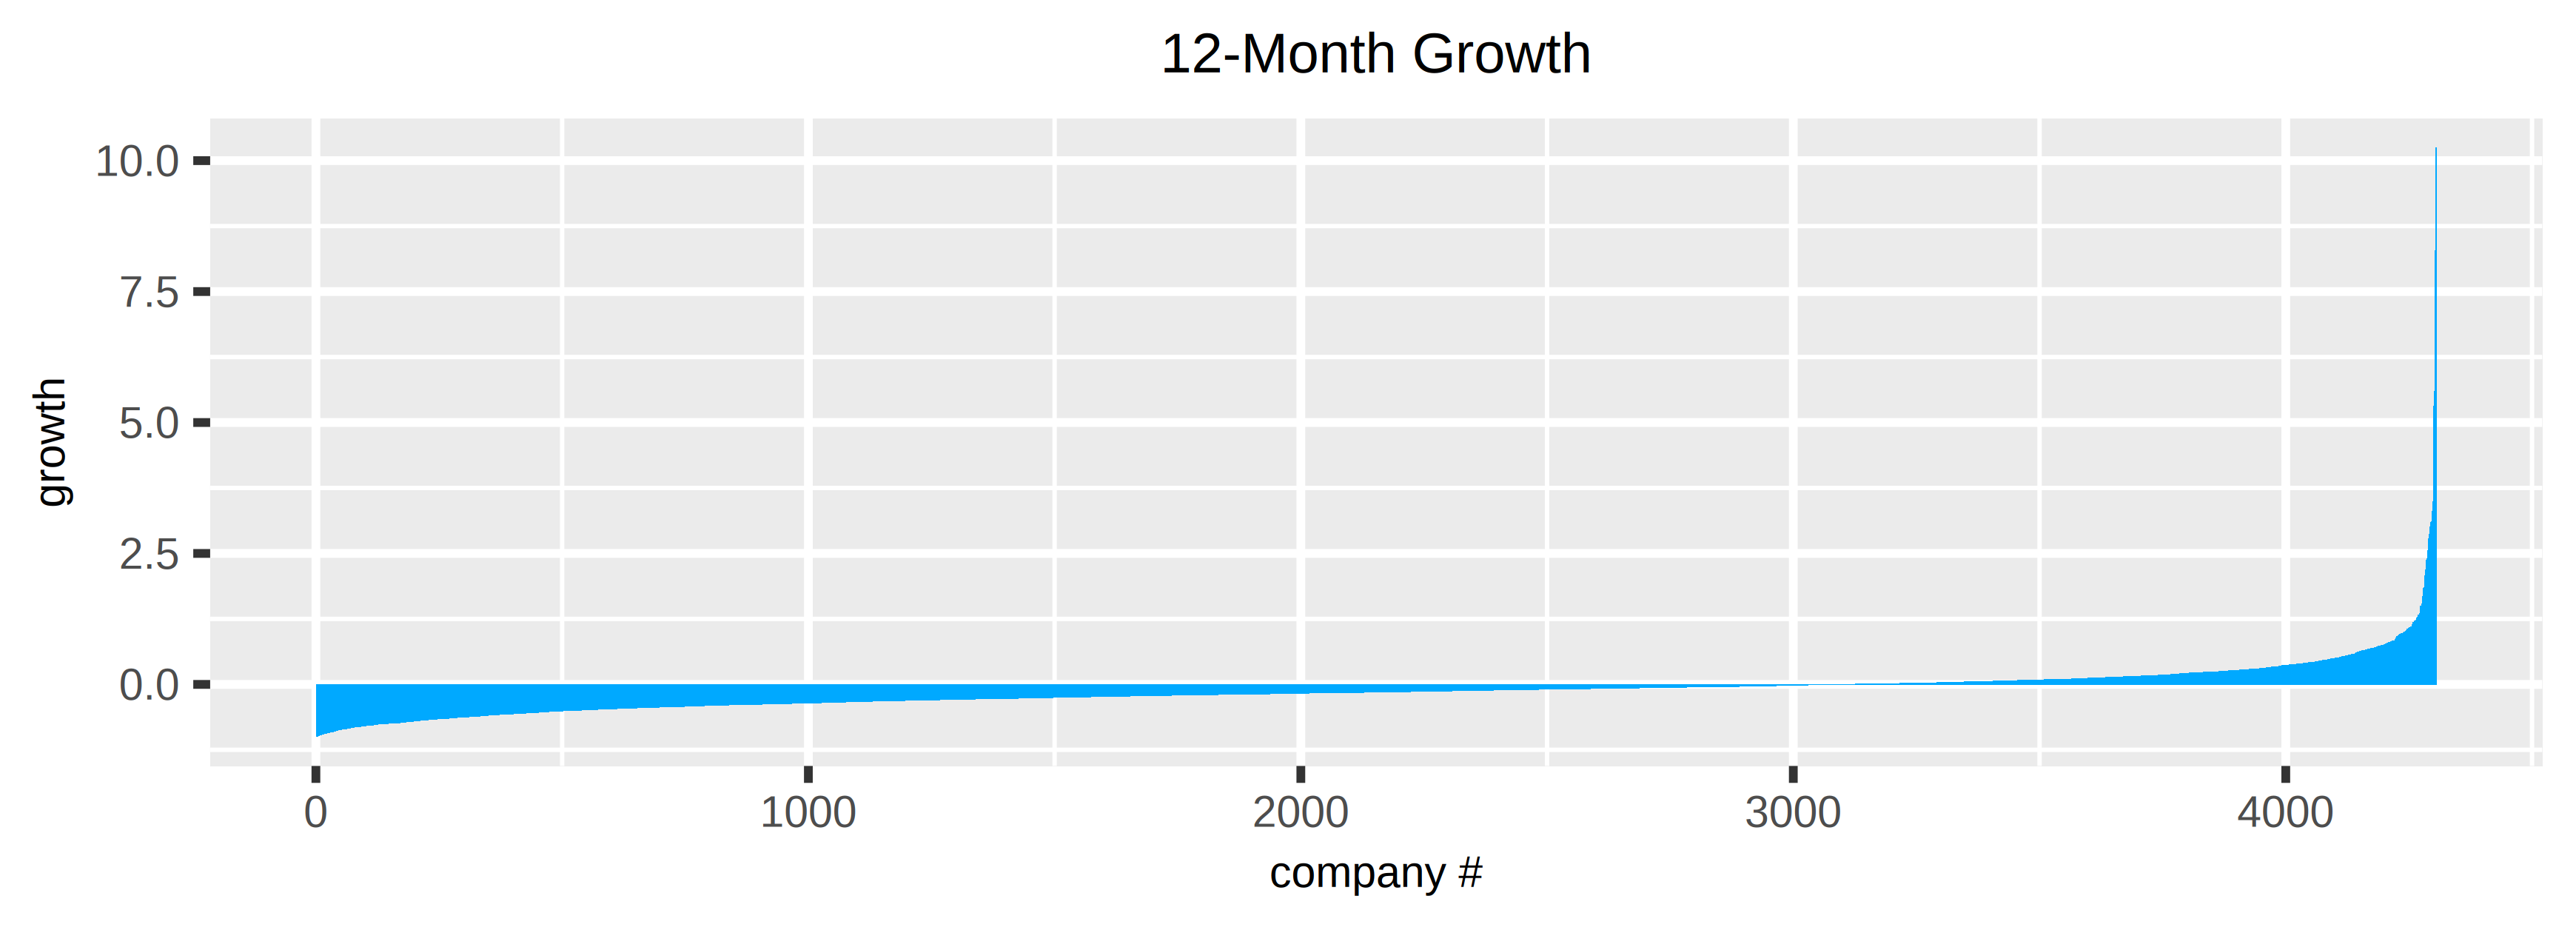

In [86]:
# Visualize growth across companies.

ggplot(final_data) + geom_col(aes(x=rank(growth, ties.method="first"), y=growth)) + xlab("company #")+ ylab("growth") + ggtitle("12-Month Growth")


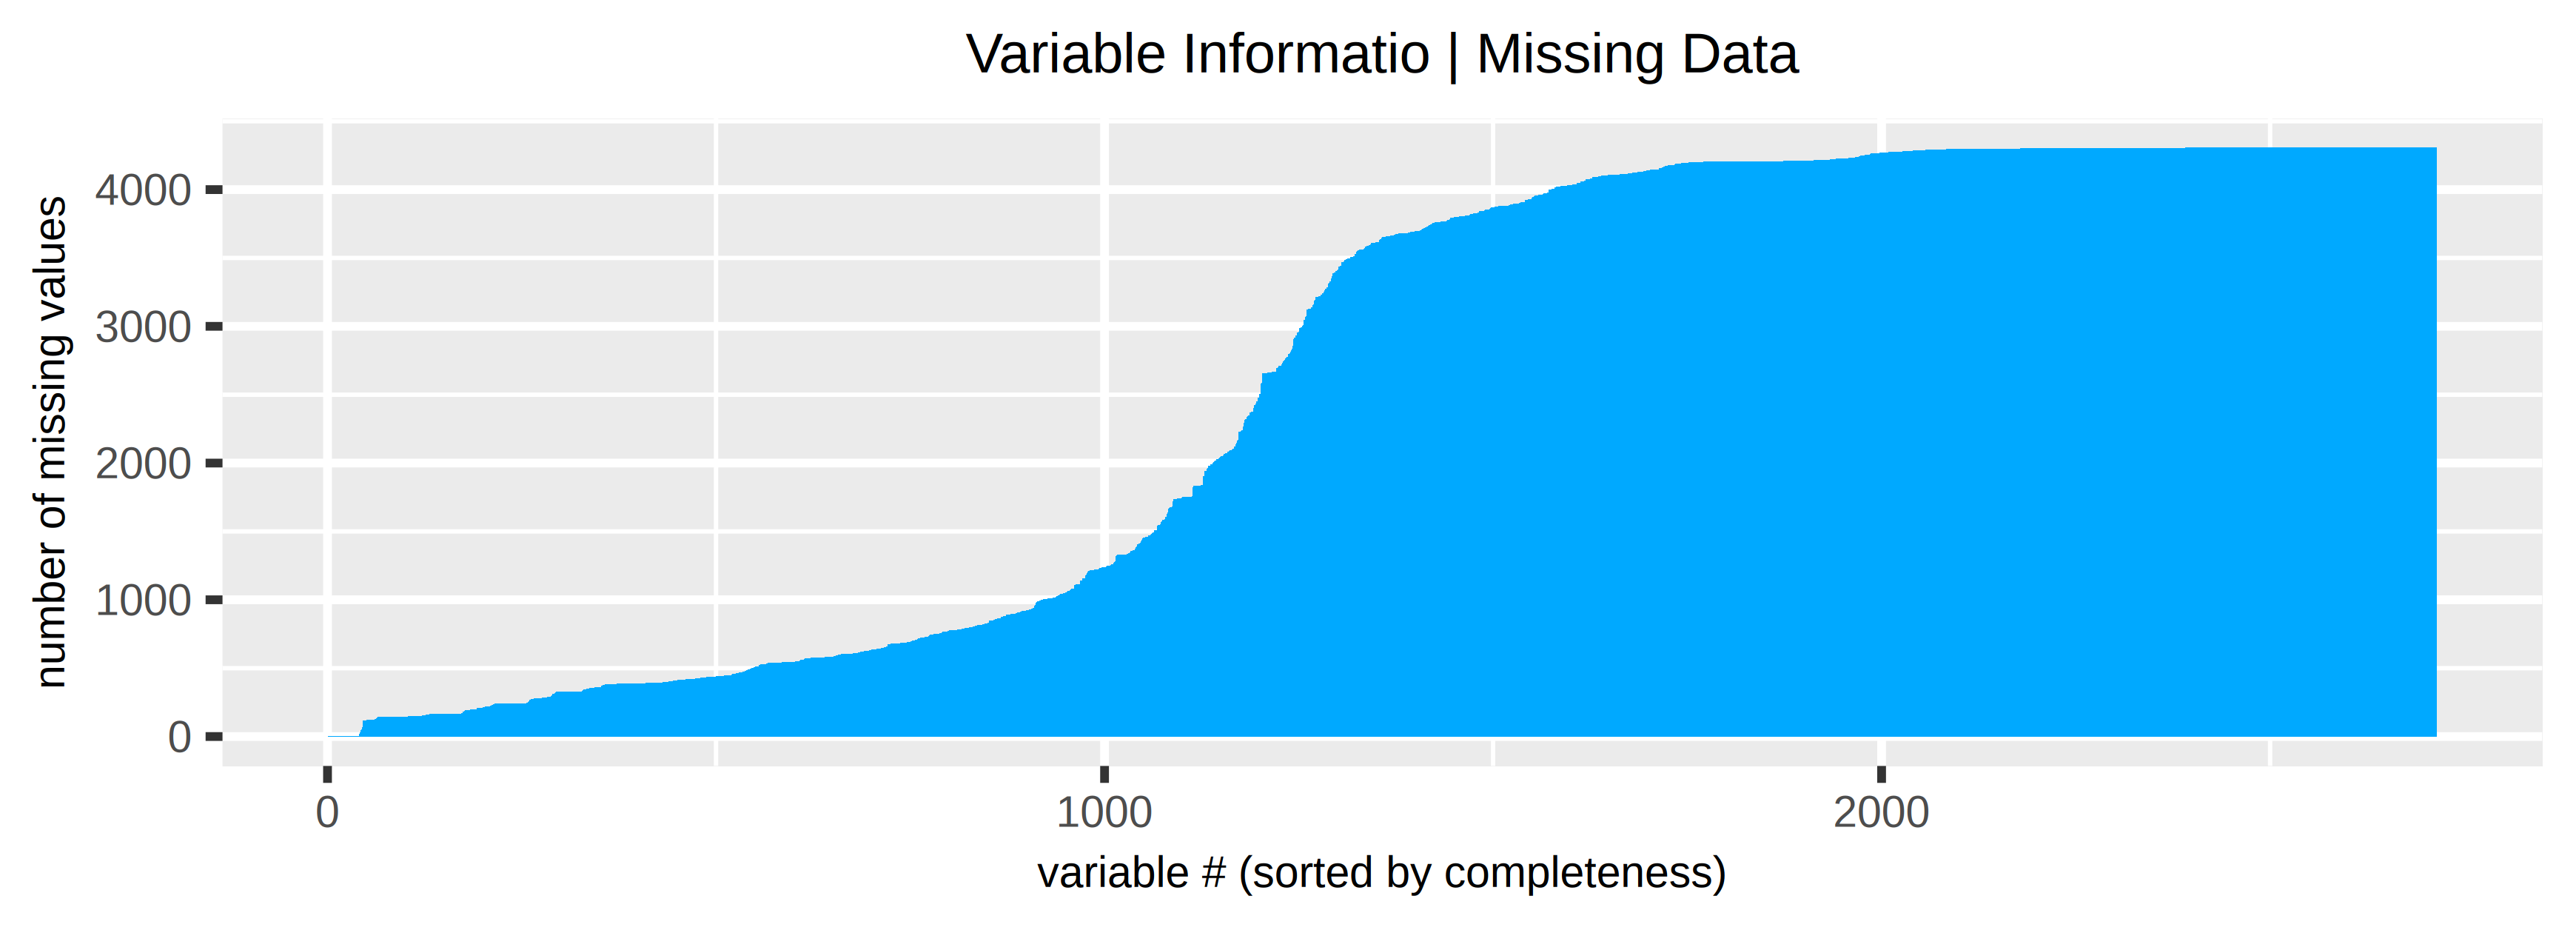

In [87]:
# Visualize the amount of missing data across variables.

total_missing <- data.frame(variable = names(final_data) ,na_count =as.numeric(summarize_all(final_data, ~sum(is.na(.)))))
ggplot(total_missing) + geom_col(aes(x=rank(na_count, ties.method="first"), y = na_count)) + xlab("variable # (sorted by completeness)") +
ylab("number of missing values") + ggtitle("Variable Informatio | Missing Data")

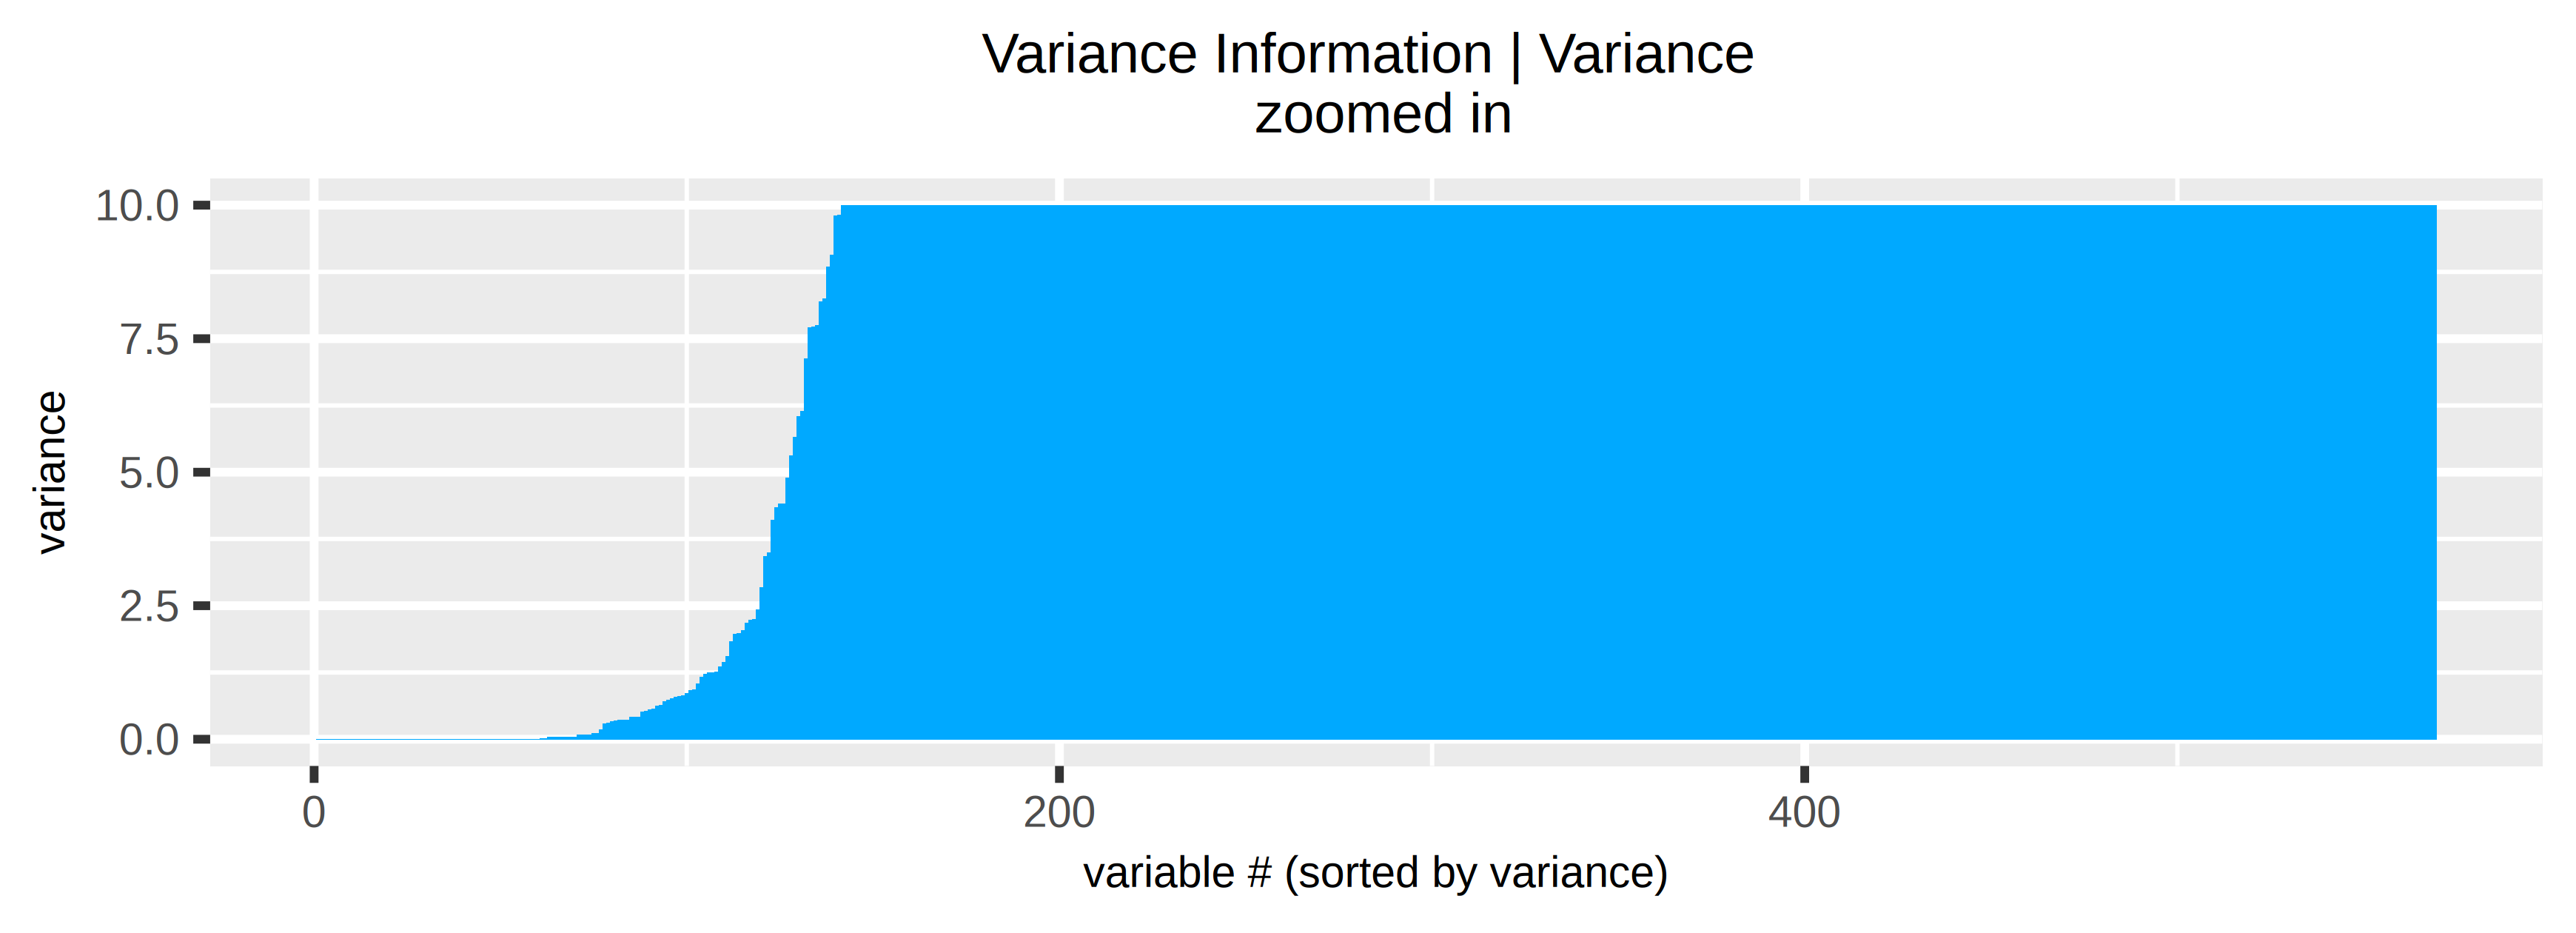

In [90]:
# Show another interesting visualization.
df <- select_if(data, is.numeric)
variance_values <- summarize_all(df, ~var(., na.rm = TRUE))
variance_values <- as.numeric(variance_values[1, ])
adjusted_df <- data.frame( variable = names(df), variance = variance_values)
adjusted_df$variance_zoomed_in <- pmin(adjusted_df$variance, 10)
adjusted_df$variance_zoomed_out <- pmin(adjusted_df$variance, 10000000)
ggplot(adjusted_df) + geom_col(aes(x=rank(variance, ties.method = "first"), y = variance_zoomed_in)) + xlab("variable # (sorted by variance)") +
ylab("variance") + ggtitle("Variance Information | Variance \n zoomed in")

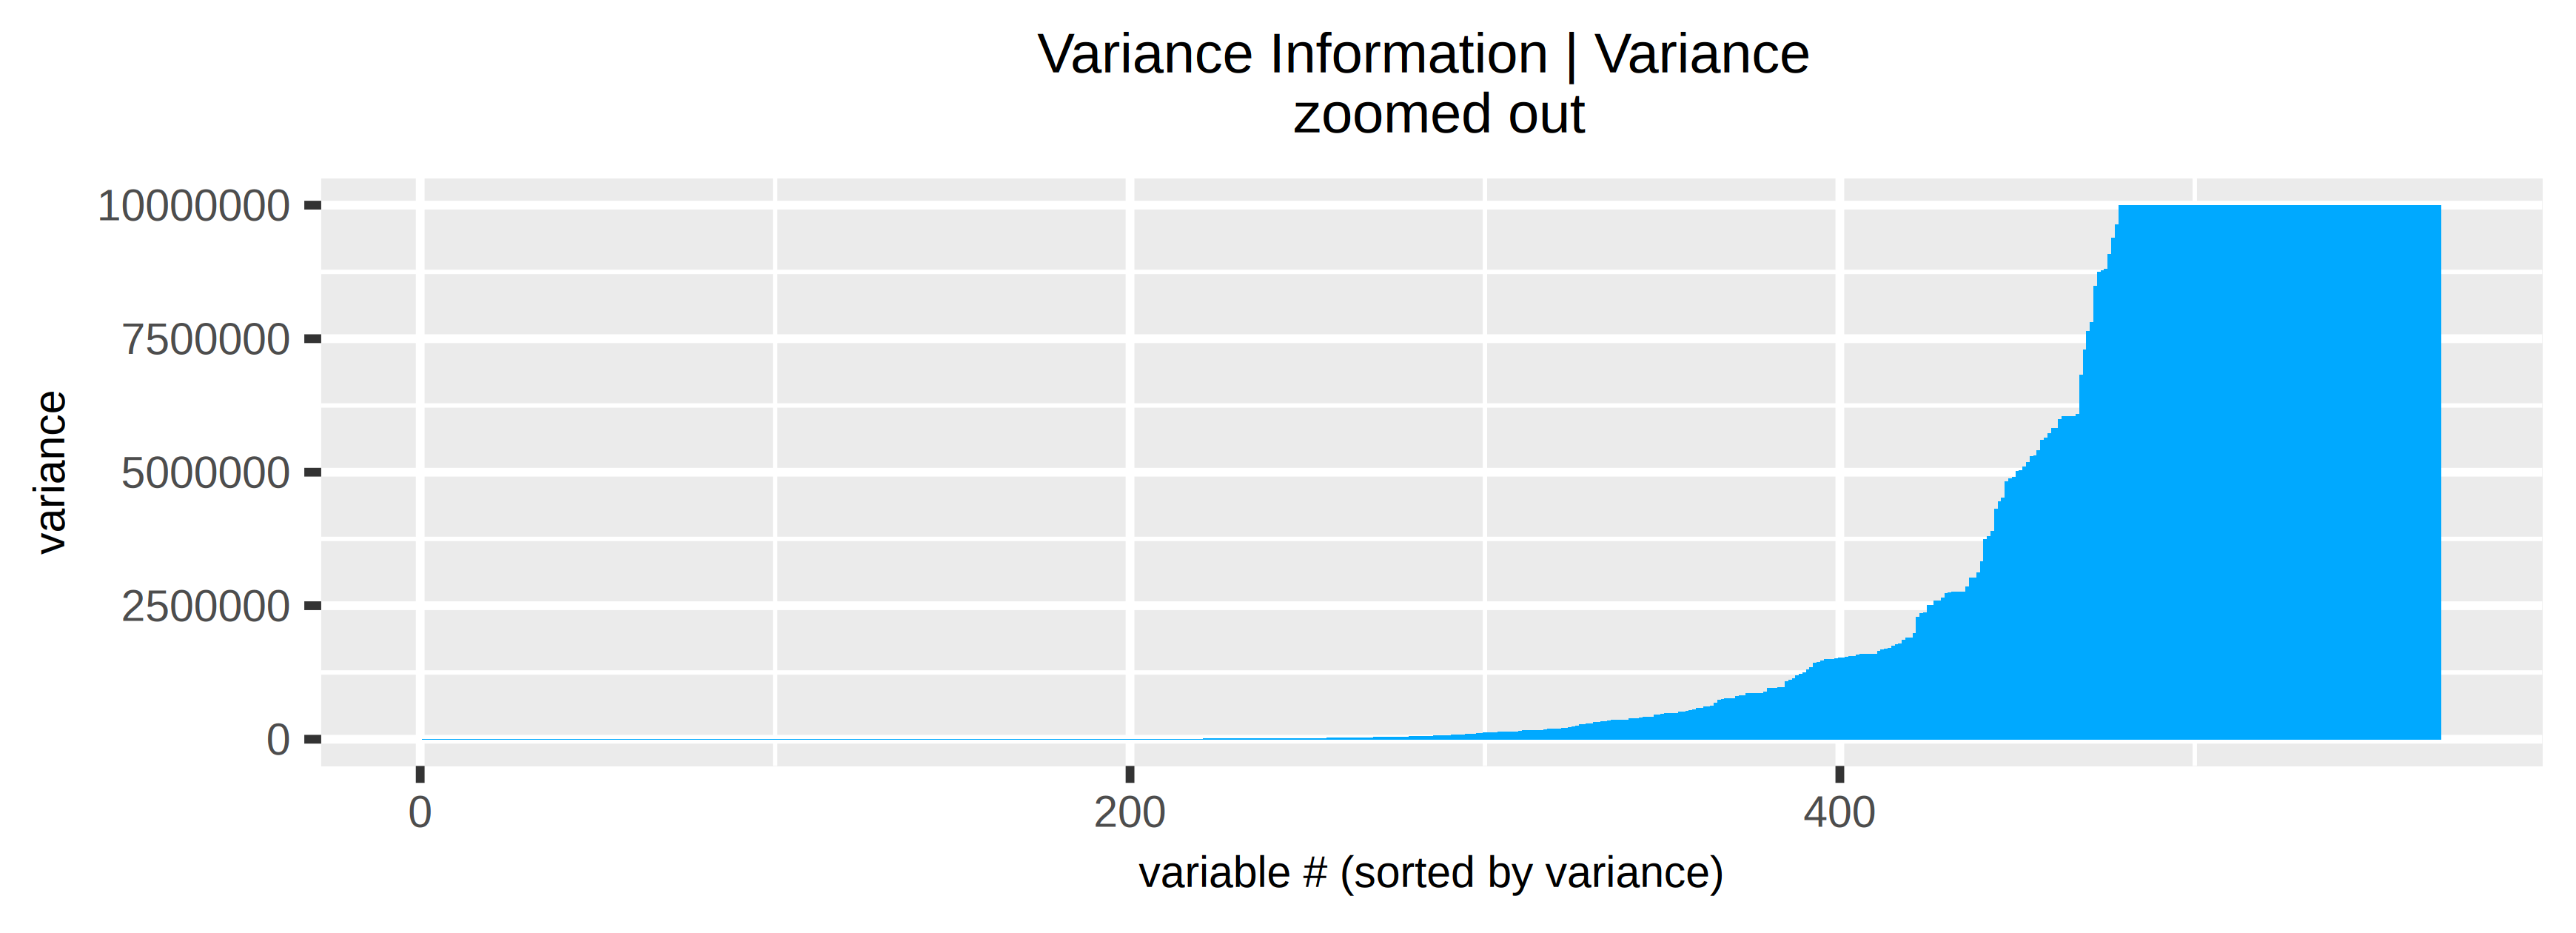

In [91]:
# Show another interesting visualization.
ggplot(adjusted_df) + geom_col(aes(x=rank(variance, ties.method="first"), y = variance_zoomed_out)) + xlab("variable # (sorted by variance)") +
ylab("variance") + ggtitle("Variance Information | Variance \n zoomed out")



## Data Transformation

Transform data representation:

* Filter the data to include only predictor variables with at least 95% non-missing values.
* Impute missing data ...
  * for each numerical variable, use the mean of non-missing values
  * for each non-numerical variable, use the mode of non-missing values
* Filter the data to include only numerical variables with non-zero variance.
* Transform normalized numerical predictor variables to principal component representation.
* Restore the outcome and identifier variables.
* Filter in outcome and identifier variables, and first three principal components.

In [185]:
# Specify outcome, identifier, and predictor variables.
# Filter out sparse variables.
# Impute missing data.
# Transform numerical predictor variables to principal component representation
# Restore the outcome and identifier variables to the data.
# Filter in outcome and identifier variables, and first three principal components.
# How many observations and variables?
# Show first few observations of transformed data.

id_vars = c("gvkey", "tic", "conm")
outcome_vars = c("growth", "big_growth")
extra_vars   <- c("prccq")
predictor_var <- final_data[, setdiff(colnames(final_data),c(id_vars, outcome_vars, extra_vars))]
df_after = select_if(predictor_var, ~ mean(is.na(.)) < 0.05)
columns = colnames(df_after)
final_df = predictor_var[, columns]

for (col in colnames(final_df)) {
if (is.numeric(final_df[[col]])) {
value <- mean(final_df[[col]], na.rm = TRUE)
final_df[[col]][is.na(final_df[[col]])] <- value 
    } else {
        tab <- table(final_df[[col]])
        mode_val <- names(tab)[which.max(tab)]
        final_df[[col]][is.na(final_df[[col]])] <- mode_val
    }
}

numeric_cols = sapply(final_df, is.numeric)
final_df_num = final_df[, numeric_cols]
nonzero_var = sapply(final_df_num, function(x) var(x) > 0)
final_df_num = final_df_num[, nonzero_var]
set.seed(0)
pc = prcomp(final_df_num, scale. = TRUE, center = TRUE)
data.pc = as.data.frame(pc$x)
needed = data.pc[,1:3]
colnames(needed) <- c("PC1", "PC2", "PC3")
data <- cbind(final_data[, c(extra_vars,id_vars, outcome_vars)],needed)
data = data[,c(6,5,1,2,3,4,7,8,9)]
fmtx(size(data))
fmtx(data[1:6,],FFO)

observations,variables
"4,305",9


big_growth,growth,prccq,gvkey,tic,conm,PC1,PC2,PC3
NO,0.0507,43.69,"1,004",AIR,AAR CORP,1.4190,0.2147,-0.1874
NO,-0.3829,32.11,"1,045",AAL,AMERICAN AIRLINES GROUP INC,-2.8005,0.2266,1.4365
YES,0.3158,6.75,"1,050",CECE,CECO ENVIRONMENTAL CORP,1.5337,0.4418,-0.1679
NO,-0.2165,8.66,"1,062",ASA,ASA GOLD AND PRECIOUS METALS,1.5823,0.6405,0.0122
NO,-0.1185,15.25,"1,072",AVX,AVX CORP,1.2903,0.4551,0.0929
NO,0.0002,85.20,"1,075",PNW,PINNACLE WEST CAPITAL CORP,0.3787,-0.4840,-0.0129


## Model 1

Model 1 is a naive Bayes classifier that predicts whether or not a company stock price will grow by 30% or more at 12 months.

In [152]:
# Build, evaluate, and tune a naive Bayes model by iterating through PC1, PC2, PC3 
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 

set.seed(0)
folds = createFolds(data$big_growth, k = 5)
combinations = list(c("PC1"), c("PC2"), c("PC3"), c("PC1", "PC2"), c("PC1", "PC3"), c("PC2", "PC3"), c("PC1", "PC2", "PC3"))
iteration_df = data.frame(method = character(), variables = character(), profit.cv = numeric(),stringsAsFactors = FALSE)
new_df = data.frame(fold = c(1,2,3,4,5), accuracy =c(0,0,0,0,0))
for (k in 1:7) {
variables = combinations[[k]]
profit = numeric(5)
for (p in 1:5){
    testing_index = folds[[p]]
    training_data <- data[-testing_index, ]
    testing_data  <- data[testing_index, ]
    model <- naiveBayes(x = training_data[, variables, drop = FALSE],y = training_data$big_growth,laplace = TRUE)
    probability_yes = predict(model, testing_data, type = 'raw')[,'YES']
    top_indexs <- order(probability_yes, decreasing = TRUE)[1:portfolio_size]
    companies = testing_data[top_indexs, ]
    profit[p] <- sum((1 + companies$growth) * allocation) - budget
}
iteration_df <- rbind(iteration_df, data.frame(method="naive bayes",variables=paste(c(variables, "big_growth"),collapse = ", "),
profit.cv = mean(profit),stringsAsFactors = FALSE))
}
best_model = iteration_df[3,]
fmtsx(fmt(allocation),fmt(iteration_df, "search for best model"),fmt(best_model))

allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


## Model 2

Model 2 is a linear regression regressor that predicts company growth at 12 months.

In [160]:
# Build, evaluate, and tune a linear regression model by iterating through PC1, PC2, PC3
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 


set.seed(0)
folds = createFolds(data$growth, k = 5)
combinations = list(c("PC1"), c("PC2"), c("PC3"), c("PC1", "PC2"), c("PC1", "PC3"), c("PC2", "PC3"), c("PC1", "PC2", "PC3"))
iteration_df = data.frame(method = character(), variables = character(), profit.cv = numeric(),stringsAsFactors = FALSE)
new_df = data.frame(fold = c(1,2,3,4,5), accuracy =c(0,0,0,0,0))
for (k in 1:7) {
variables = combinations[[k]]
profit = numeric(5)
for (p in 1:5){
    testing_index = folds[[p]]
    training_data <- data[-testing_index, ]
    testing_data  <- data[testing_index, ]
    formula  <- as.formula(paste("growth ~", paste(variables, collapse = " + ")))
    model <- lm(formula, data = training_data)
    pred_growth <- predict(model, newdata = testing_data)
    top_indexs <- order(pred_growth, decreasing = TRUE)[1:portfolio_size]
    companies = testing_data[top_indexs, ]
    profit[p] <- sum((1 + companies$growth) * allocation) - budget
}
iteration_df <- rbind(iteration_df, data.frame(method="linreg",variables=paste(c(variables, "growth"),collapse = ", "),
profit.cv = mean(profit),stringsAsFactors = FALSE))
}
best_model <- iteration_df[which.max(iteration_df$profit.cv), ]
fmtsx(fmt(allocation),fmt(iteration_df, "search for best model"),fmt(best_model))

allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


## Model 3

I wanted to try a Neural network approach. I basically did the same thing as the previous models but used NN instead to get my predictions.

In [168]:
# Build, evaluate, and tune a linear regression model by iterating through PC1, PC2, PC3
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 
library(nnet)

set.seed(0)
folds = createFolds(data$growth, k = 5)
combinations = list(c("PC1"), c("PC2"), c("PC3"), c("PC1", "PC2"), c("PC1", "PC3"), c("PC2", "PC3"), c("PC1", "PC2", "PC3"))
iteration_df = data.frame(method = character(), variables = character(), profit.cv = numeric(),stringsAsFactors = FALSE)
new_df = data.frame(fold = c(1,2,3,4,5), accuracy =c(0,0,0,0,0))
hidden_layers = 3
for (k in 1:7) {
variables = combinations[[k]]
profit = numeric(5)
for (p in 1:5){
    testing_index = folds[[p]]
    training_data <- data[-testing_index, ]
    testing_data  <- data[testing_index, ]
    formula  <- as.formula(paste("growth ~", paste(variables, collapse = " + ")))
    neur_model = nnet(formula, data = training_data, size = hidden_layers, linout = TRUE,trace = FALSE,maxit = 500)
    prediction <- as.numeric(predict(neur_model, newdata = testing_data))
    top_indexs <- order(prediction, decreasing = TRUE)[1:portfolio_size]
    companies = testing_data[top_indexs, ]
    profit[p] <- sum((1 + companies$growth) * allocation) - budget
}
iteration_df <- rbind(iteration_df, data.frame(method="neuralnet",variables=paste(c(variables, "growth"),collapse = ", "),
profit.cv = mean(profit),stringsAsFactors = FALSE))
}
best_model <- iteration_df[which.max(iteration_df$profit.cv), ]
fmtsx(fmt(allocation),fmt(iteration_df, "search for best model"),fmt(best_model))



allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


## Model 4

Trying Naive Bayes but I tuned the laplace parameter to hopefully get a better model.

In [202]:
# Build, evaluate, and tune a model.
# Show the allocations assumed, predictor variable/hyperparameter combination and estimated profit
# for the searched and best performing models. 

set.seed(0)
folds = createFolds(data$big_growth, k = 5)
combinations = list(c("PC1"), c("PC2"), c("PC3"), c("PC1", "PC2"), c("PC1", "PC3"), c("PC2", "PC3"), c("PC1", "PC2", "PC3"))
iteration_df = data.frame(method = character(), variables = character(), profit.cv = numeric(),stringsAsFactors = FALSE)
new_df = data.frame(fold = c(1,2,3,4,5), accuracy =c(0,0,0,0,0))
for (k in 1:7) {
variables = combinations[[k]]
profit = numeric(5)
for (p in 1:5){
    testing_index = folds[[p]]
    training_data <- data[-testing_index, ]
    testing_data  <- data[testing_index, ]
    model <- naiveBayes(x = training_data[, variables, drop = FALSE],y = training_data$big_growth,laplace = 2)
    probability_yes = predict(model, testing_data, type = 'raw')[,'YES']
    top_indexs <- order(probability_yes, decreasing = TRUE)[1:portfolio_size]
    companies = testing_data[top_indexs, ]
    profit[p] <- sum((1 + companies$growth) * allocation) - budget
}
iteration_df <- rbind(iteration_df, data.frame(method="naive bayes",variables=paste(c(variables, "big_growth"),collapse = ", "),
profit.cv = mean(profit),stringsAsFactors = FALSE))
}
best_model = iteration_df[3,]
fmtsx(fmt(allocation),fmt(iteration_df, "search for best model"),fmt(best_model))

allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


## Model 5

I added pairwise interactions in my formula, like growth ~ PC1 + PC2, is now (PC1 + PC2)^2. I did this while playing around but hopefully it helps with making predictions.

In [204]:
# Build, evaluate, and tune a model.
# Show the allocations assumed, predictor variable/hyperparameter combination and estimated profit
# for the searched and best performing models. 

# Build, evaluate, and tune a linear regression model by iterating through PC1, PC2, PC3
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 


set.seed(0)
folds = createFolds(data$growth, k = 5)
combinations = list(c("PC1"), c("PC2"), c("PC3"), c("PC1", "PC2"), c("PC1", "PC3"), c("PC2", "PC3"), c("PC1", "PC2", "PC3"))
iteration_df = data.frame(method = character(), variables = character(), profit.cv = numeric(),stringsAsFactors = FALSE)
new_df = data.frame(fold = c(1,2,3,4,5), accuracy =c(0,0,0,0,0))
for (k in 1:7) {
variables = combinations[[k]]
profit = numeric(5)
for (p in 1:5){
    testing_index = folds[[p]]
    training_data <- data[-testing_index, ]
    testing_data  <- data[testing_index, ]
    formula <- as.formula(paste("growth ~ (", paste(variables, collapse=" + "), ")^2"))
    model <- lm(formula, data = training_data)
    pred_growth <- predict(model, newdata = testing_data)
    top_indexs <- order(pred_growth, decreasing = TRUE)[1:portfolio_size]
    companies = testing_data[top_indexs, ]
    profit[p] <- sum((1 + companies$growth) * allocation) - budget
}
iteration_df <- rbind(iteration_df, data.frame(method="linreg",variables=paste(c(variables, "growth"),collapse = ", "),
profit.cv = mean(profit),stringsAsFactors = FALSE))
}
best_model <- iteration_df[which.max(iteration_df$profit.cv), ]
fmtsx(fmt(allocation),fmt(iteration_df, "search for best model"),fmt(best_model))

allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


## Model 6

Increased my hidden layers for the NN from 3 all the way up to 10. Hopfeully making it predict stronger but definitely increasing my chances of having it over fit.

In [205]:
# Build, evaluate, and tune a model.
# Show the allocations assumed, predictor variable/hyperparameter combination and estimated profit
# for the searched and best performing models. 

# Build, evaluate, and tune a linear regression model by iterating through PC1, PC2, PC3
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 
library(nnet)

set.seed(0)
folds = createFolds(data$growth, k = 5)
combinations = list(c("PC1"), c("PC2"), c("PC3"), c("PC1", "PC2"), c("PC1", "PC3"), c("PC2", "PC3"), c("PC1", "PC2", "PC3"))
iteration_df = data.frame(method = character(), variables = character(), profit.cv = numeric(),stringsAsFactors = FALSE)
new_df = data.frame(fold = c(1,2,3,4,5), accuracy =c(0,0,0,0,0))
hidden_layers = 10
for (k in 1:7) {
variables = combinations[[k]]
profit = numeric(5)
for (p in 1:5){
    testing_index = folds[[p]]
    training_data <- data[-testing_index, ]
    testing_data  <- data[testing_index, ]
    formula  <- as.formula(paste("growth ~", paste(variables, collapse = " + ")))
    neur_model = nnet(formula, data = training_data, size = hidden_layers, linout = TRUE,trace = FALSE,maxit = 500)
    prediction <- as.numeric(predict(neur_model, newdata = testing_data))
    top_indexs <- order(prediction, decreasing = TRUE)[1:portfolio_size]
    companies = testing_data[top_indexs, ]
    profit[p] <- sum((1 + companies$growth) * allocation) - budget
}
iteration_df <- rbind(iteration_df, data.frame(method="neuralnet",variables=paste(c(variables, "growth"),collapse = ", "),
profit.cv = mean(profit),stringsAsFactors = FALSE))
}
best_model <- iteration_df[which.max(iteration_df$profit.cv), ]
fmtsx(fmt(allocation),fmt(iteration_df, "search for best model"),fmt(best_model))



allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


## Investment Opportunities

Test the best performing model on new investment opportunities.

### Retrieve Investment Data

In [21]:
# Retrieve the investment opportunities data.
# How many observations and variables?

data.io = read.csv("Investment Opportunities.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.io))

observations,variables
918,680


### Prepare Investment Data

In [173]:
# Prepare the investment opportunities data as appropriate for transformation.
# How many observations and variables?

dont_touch = c('gvkey', 'tic', 'conm')

data.io$datadate <- as.Date(data.io$datadate, format = "%m/%d/%Y")
q1 <- data.io[quarter(data.io$datadate) == 1 & !is.na(data.io$prccq), ]
q2 <- data.io[quarter(data.io$datadate) == 2 & !is.na(data.io$prccq), ]
q3 <- data.io[quarter(data.io$datadate) == 3 & !is.na(data.io$prccq), ]
q4 <- data.io[quarter(data.io$datadate) == 4 & !is.na(data.io$prccq), ]
remove_extra = function(df) {
df[!duplicated(df$gvkey), ]
                    }
q1 <- remove_extra(q1)
q2 <- remove_extra(q2)
q3 <- remove_extra(q3)
q4 <- remove_extra(q4)

for (i in 1:ncol(q1)){
    name <- colnames(q1)[i]
    if (!(name %in% dont_touch)) {
        colnames(q1)[i] <- paste0(name,'.q1')
    }
}
for (i in 1:ncol(q2)){
    name <- colnames(q2)[i]
    if (!(name %in% dont_touch)) {
        colnames(q2)[i] <- paste0(name,'.q2')
    }
}
for (i in 1:ncol(q3)){
    name <- colnames(q3)[i]
    if (!(name %in% dont_touch)) {
        colnames(q3)[i] <- paste0(name,'.q3')
    }
}
for (i in 1:ncol(q4)){
    name <- colnames(q4)[i]
    if (!(name %in% dont_touch)) {
        colnames(q4)[i] <- paste0(name,'.q4')
    }
}

merged <- merge(q1, q2, by = c("gvkey","tic","conm"), all = TRUE)
merged <- merge(merged, q3, by = c("gvkey","tic","conm"), all = TRUE)
final <- merge(merged, q4, by = c("gvkey","tic","conm"), all = TRUE)
fmtx(size(final),'size(data.current)')

observations,variables
230,"2,711"


### Transform Investment Data

In [183]:
# Transform the prepared investment dataset as apprpriate for use with the
# best performing model.
# How many observations and variables?
# Show the first few observations of the resulting dataset.

cn = readRDS("My Filter.rds")
ml = readRDS("My Imputation.rds")
pc = readRDS("My PC.rds")
prevars = readRDS("My Predictors.rds")
id_vars   <- c("gvkey", "tic", "conm")
data_p = final[,cn, drop = FALSE]
value = put_impute(data_p,ml)
components = predict(pc, newdata = value)
data.real = cbind(final[, id_vars, drop=FALSE], components[,1:3, drop=FALSE])
fmtx(size(data.real))
fmtx(data.real[1:6], FFO)

observations,variables
230,6


gvkey,tic,conm,PC1,PC2,PC3
"1,004",AIR,AAR CORP,1.4289,0.0603,-0.2578
"1,410",ABM,ABM INDUSTRIES INC,1.0651,0.0750,-0.1603
"1,562",AMSWA,AMERICAN SOFTWARE -CL A,1.6393,0.3246,-0.1280
"1,618",AXR,AMREP CORP,0.8970,0.1474,-0.6411
"1,632",ADI,ANALOG DEVICES,-1.6145,-0.4834,-0.9772
"1,686",APOG,APOGEE ENTERPRISES INC,1.4313,-0.1506,-0.3698
"1,704",AMAT,APPLIED MATERIALS INC,-5.0404,0.1981,-1.5421
"1,706",EPAC,ACTUANT CORP -CL A,1.3552,0.4067,-0.2061
"1,820",ALOT,ASTRONOVA INC,1.6354,0.2683,-0.2531
"1,864",REX,REX AMERICAN RESOURCES CORP,1.4840,-0.7726,-0.4143


## Apply Model

### Build Best Model

In [206]:
# Build the best performing model using all 2017 and 2018 data for training.

final_pick_mod = nnet(growth ~ PC1 + PC2, data = data, size = 10, linout = TRUE, maxit = 1000, trace = FALSE)
final_pick_mod

a 2-10-1 network with 41 weights
inputs: PC1 PC2 
output(s): growth 
options were - linear output units 

### Recommend Portfolio

In [209]:
# Use the model to inform the decision about how to fill the portfolio with companies
# from the investment opportunities.
# Show the portfolio: gvkey, tic, conm, allocation

growth = predict(final_pick_mod, newdata = data.real)
top_12 = order(growth, decreasing = TRUE)[1:portfolio_size]
portfolio = data.real[top_12,c("gvkey", "tic", "conm")]
portfolio$allocation <- allocation
fmtx(portfolio)

gvkey,tic,conm,allocation
"163,612",IGD,VOYA GLB EQ DIV AND PREM OPP,"83,333"
"14,672",IAF,ABERDEEN AUSTRALIA EQTY FD,"83,333"
"2,435",BF.B,BROWN FORMAN CORP,"83,333"
"106,133",DSU,BLACKROCK DEBT STRATEGIES FD,"83,333"
"25,024",FCO,ABERDEEN GLOBAL INCOME FD,"83,333"
"14,770",GIM,TEMPLETON GLOBAL INCOME FUND,"83,333"
"178,248",SRV,CUSHING MLP & INFASTCR TR FD,"83,333"
"175,887",IRR,VOYA NATURAL RES EQ INCM FD,"83,333"
"165,439",IGA,VOYA GLOBAL ADV AND PREM OPP,"83,333"
"177,053",IAE,VOYA ASIA PAC HI DIV EQ INCM,"83,333"


### Store Portfolio Recommendation

In [210]:
write.csv(portfolio, paste0(analyst, "-final.csv"), row.names=FALSE)

### Confirm That Format Is Correct

In [211]:
portfolio.retrieved = read.csv(paste0(analyst, "-final.csv"), header=TRUE)
opportunities = unique(read.csv("Investment Opportunities.csv", header=TRUE)$gvkey)

columns = all(colnames(portfolio.retrieved) == c("gvkey", "tic", "conm", "allocation"))
companies = all(portfolio.retrieved$gvkey %in% opportunities)
allocations = round(sum(portfolio.retrieved$allocation)) == budget
                         
check = data.frame(analyst, columns, companies, allocations)
fmtx(check, "Portfolio Recommendation | Format Check")

analyst,columns,companies,allocations
Donovan Bradley,TRUE,TRUE,TRUE


## Discussion

Hi , so I ended up using model 6 to make the predictions. This was simply because I trust neural net works the most and also it definitely preformed the best on the test we were given. The only thing that I was somewhat worried about was potientially overfitting the model but honestly I think the results came out pretty good. I found tuning the models pretyy difficult because for some reason I wasn't entirely sure about what I was capable of improving. A big thing I learned from this project is when a Linear regression model is having issues with making accurate predictions it's a good idea to explore the idea of adding dimensionality to your formula. Doing this will take your predictions off of a linear line and put them on a 3D plane or even 4D which in theory will increase prediction accuracy in the long run. Also , Importantly a lot of the things we learned in this class will without a doubt be used in my future. I think Linear regression models or even exploratory analysis will definitely be a vast vajority of my work considering I really want to go into business analytics. From my understanding a good portion of data analysis is genuinely jus eda and it's definitely really exciting that now I have even more tools to add on to my future role as a data scientist. Also It was really cool to have almost a "real world" experience using principal component analysis because I was kinda confused on the meaning and application of it. This project taught me when and how to use prinicipal component analysis and why you should probably consider it when building prediction models.

<p style="text-align:left; font-size:10px;">
Copyright (c) Huntsinger Associates, LLC
<span style="float:right;">
Document revised March 29, 2024
</span>
</p>